<a href="https://colab.research.google.com/github/cristianolate/jupyter_notebooks/blob/main/PCA_IES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Agrupación de IES chilenas
En este ejercicio se aplica una metodología de reducción de dimensionalidad de datos de universidades publicados por SIES, para su posterior representación gráfica y agrupación.

## Librerías
Se utiliza la librería Scikit-learn para aplicar PCA y k-means.

In [1]:
import io
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Los datos
Los datos utilizados son los publicados en el portal [Mi Futuro](https://www.mifuturo.cl/) por la Subsecretaría de Educación Superior y corresponden al compilado denominado [Buscador de Instituciones](https://www.mifuturo.cl/wp-content/uploads/2022/12/Buscador_Instituciones_2022_2023_SIES.xlsx), que contiene para su edición 2022-2023 información de 97 variables para 130 instituciones de educación superior, entre institutos profesionales, centros de formación técnica y universidades.

Las variables pueden agruparse de la siguiente manera:
*   **Información general**: nombre, tipo de institución, dirección postal, acreditación, entre otras.
*   **Información financiera**: principio contable, activos, pasivos, patrimonio, resultados financieros, entre otras.
*   **Información de estudiantes de pregrado**: matrícula total, matrícula por área del conocimiento, retención, titulación, entre otras.
*   **Información de estudiantes de postgrado**: matrícula total y titulación.
*   **Información de académicos**: cantidad y porcentaje de Jornadas Completas Equivalentes (JCE) según grado y razón de JCE por estudiante de pregrado.
*   **Información de infraestructura**: metros cuadrados construídos, laboratorios y tralleres, computadores, áreas verdes, entre otras.

Las variables numéricas (y que pueden ser utilizadas para PCA) son 80; quitando algunas columnas calculadas, se reducen a 71. Por otro lado, al filtrar las universidades, se obtienen 54 observaciones; de estas, 6 quedan fuera del análisis al no presentar, por distintos motivos, información para alguna de las 71 variables (Universidad de Aysén, Universidad de Magallanes, Universidad Bolivariana, Universidad Los Leones, Universidad Miguel
de Cervantes y Universidad Tecnológica de Chile INACAP).

Se parametrizan las columnas del archivo de datos de IES de SIES que serán utilizadas para el análisis, la columna y filtro a aplicar (en este caso, para filtrar sólo Universidades):

In [2]:
# Parámetros varios
cols_idx = [5] + [i for i in range(15, 97)] # Columnas a utilizar
rows2skip = 2                               # Filas para saltarse
type_ies_col = 'Tipo de institución'        # Columna con el tipo de IES
type_ies_value = 'Universidades'            # Valor de la columna tipo IES a filtrar
id_ies_col = 'Página web'                   # Columna con el código de la IES

Se cargan los datos disponibles en el sitio de [Mi Futuro](https://www.mifuturo.cl/):

In [3]:
# Archivo con datos 2022
xls_file = files.upload()
data = pd.read_excel(io.BytesIO(list(xls_file.values())[0]), skiprows=rows2skip)

Saving Buscador_Instituciones_2022_2023_SIES (5).xlsx to Buscador_Instituciones_2022_2023_SIES (5) (1).xlsx


In [4]:
# Se filtran las Universidades y seleccionan las columnas listadas
ues_data = data[data[type_ies_col] == type_ies_value].iloc[:, cols_idx]

# Se deja solamente el nombre del dominio (como código de IES)
ues_data['Página web'] = ues_data['Página web'].apply(lambda x: str(x).replace('www.', '').replace('.cl', '').upper())

# Se setea el índice de las filas
ues_data = ues_data.set_index(id_ies_col)

# Remplazo de todo lo que no sea número por un NaN
ues_data = ues_data.replace(regex=[r'\D+'], value=np.nan)

# Se quitan las columnas que sólo tengan NaN
ues_data = ues_data.dropna(how="all", axis=1)

# Se quita toda fila con al menos un NaN
ues_data = ues_data.dropna()

## Análisis de Componentes Principales
El [Análisis de Componentes Principales](https://scikit-learn.org/stable/modules/decomposition.html#pca) (PCA) es una técnica de aprendizaje no supervisado que describe un conjunto de datos en términos de un conjunto de nuevas variables (o “componentes”) no correlacionadas, construidas a partir de las variables originales.

Así, siendo nuestro conjunto de datos una matriz de $48 \times 71$ representada por los vectores $X = ( X_1 \  X_2 \ ...  \ X_{71} )$, el objetivo de PCA es encontrar los vectores $Z_i$ tales que:

$$Z_i = \alpha_{1i}X_1 + \alpha_{2i}X_2 + \ ... \ \alpha_{71i}X_{71}$$

Donde los $\alpha_{ij}$ (que son conocidos como pesos) representan cuánto influye cada variable original en la componente en cuestión; adicionalmente, se cumple que $\sum_{j=1}^{71} \alpha_{ji}^2 = 1$ para todo $i$.

Antes de aplicar PCA a los datos, dado que se trata de variables con órdenes de magnitud distintas (monedas, porcentajes, cantidad de personas, cantidad de semestre, entre otros tipos de unidades), se escalan los datos.

In [5]:
scaler = StandardScaler().set_output(transform="pandas")
ues_data_scaled = scaler.fit_transform(ues_data)

Se aplica PCA a los datos escalados. Para analizar los resultados, se grafica la varianza explicada acumulada en función de la cantidad de variables (ordenadas según la varianza que explica cada componente, de mayor a menor).
Con las 2 primeras componentes ya se explica casi el 55% de la variabilidad de los datos; el 90% se alcanza con 14 componentes.

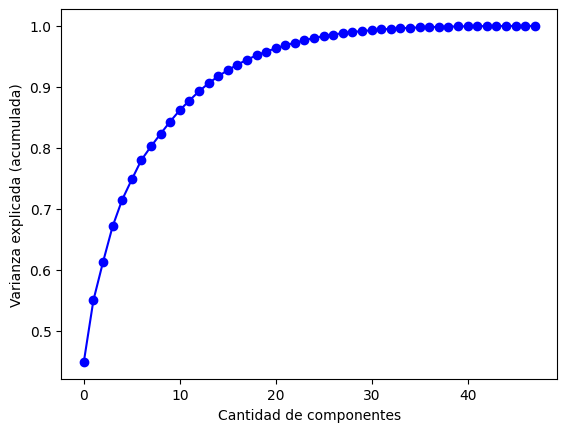

In [6]:
pca = PCA().fit(ues_data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'o-b')
plt.xlabel('Cantidad de componentes')
plt.ylabel('Varianza explicada (acumulada)');

## Agrupamiento
Los [algoritmos de agrupamiento](https://scikit-learn.org/stable/modules/clustering.html#) son técnicas, también consideradas de aprendiezaje no supervisado, que buscan separar un conjunto de vectores en grupos de acuerdo a algún criterio de similitud. Uno de los tipos de agrupamiento es el llamado "no jeráquico", en el cual la cantidad de grupos es definido con antelación; uno de los algoritmos más simples y utilizado es el de [k-means](https://scikit-learn.org/stable/modules/clustering.html#k-means) (k-medias).

Dado nuestro conjunto de observaciones $\{ x \}_{i=1}^{48}$, se busca una partición en $k$ subconjuntos $S_j$ tales que se minimice la función

$$arg \ min_S \sum_{i=1}^k \sum_{x_j \in S_i} || x_j-\mu_i ||^2$$

Donde $\mu_i$ es la media de los vectores en el conjunto $S_i$ (también llamado centroide).

Se aplica el algoritmo de agrupamiento k-means a los datos, considerando las 3 primeras componentes obtenidas con PCA y definiendo 3 grupos:

In [7]:
ues_pca = PCA(n_components=3).fit_transform(ues_data_scaled)
kmeans = KMeans(n_clusters=3, n_init=4)
group = kmeans.fit_predict(ues_pca)

ues_pca = pd.DataFrame(ues_pca, columns=['PC1', 'PC2', 'PC3'])
ues_pca['GROUP'] = list(group)
ues_pca['IES'] = list(ues_data_scaled.index.values)

# Dataframes con grupos por separado, para graficar clusters
g1 = ues_pca[ues_pca['GROUP'] == 0]
g2 = ues_pca[ues_pca['GROUP'] == 1]
g3 = ues_pca[ues_pca['GROUP'] == 2]

Graficamos las instituciones en los planos formados por la primera y segunda componentes (PC1 y PC2) y por la primera y tercera componentes (PC1 y PC3):

Text(0, 0.5, 'PC3')

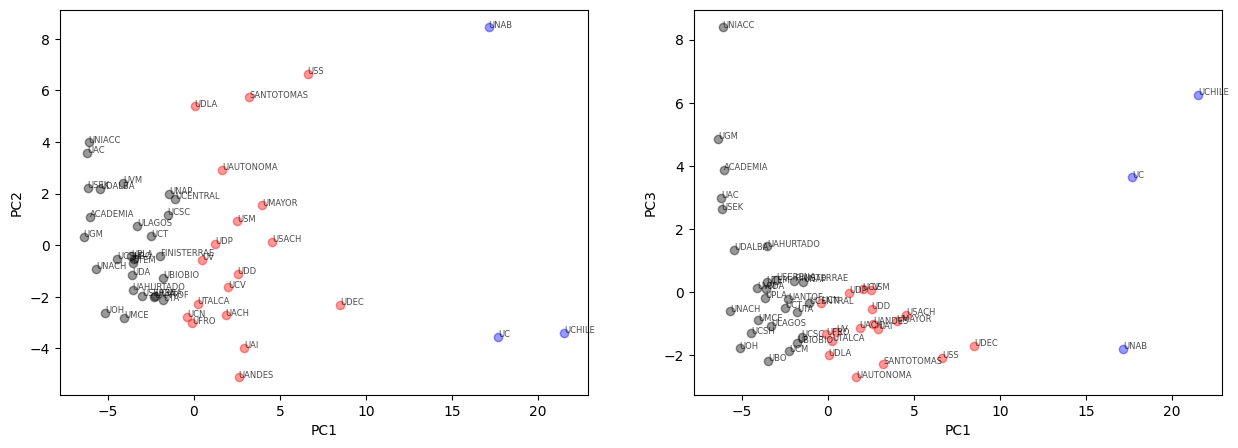

In [21]:
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# Grafico de puntos PC1-PC2
ax1.scatter(g1['PC1'], g1['PC2'], color = 'red', alpha=.4)
ax1.scatter(g2['PC1'], g2['PC2'], color = 'black', alpha=.4)
ax1.scatter(g3['PC1'], g3['PC2'], color = 'blue', alpha=.4)

# Etiquetas con los códigos de las Ues
for index, row in g1.iterrows():
  ax1.text(row['PC1'], row['PC2'], row['IES'], fontsize=6, ha='left', alpha=.7)

for index, row in g2.iterrows():
  ax1.text(row['PC1'], row['PC2'], row['IES'], fontsize=6, ha='left', alpha=.7)

for index, row in g3.iterrows():
  ax1.text(row['PC1'], row['PC2'], row['IES'], fontsize=6, ha='left', alpha=.7)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')

# Grafico de puntos PC1-PC3
ax2.scatter(g1['PC1'], g1['PC3'], color = 'red', alpha=.4)
ax2.scatter(g2['PC1'], g2['PC3'], color = 'black', alpha=.4)
ax2.scatter(g3['PC1'], g3['PC3'], color = 'blue', alpha=.4)

# Etiquetas con los códigos de las Ues
for index, row in g1.iterrows():
  ax2.text(row['PC1'], row['PC3'], row['IES'], fontsize=6, ha='left', alpha=.7)

for index, row in g2.iterrows():
  ax2.text(row['PC1'], row['PC3'], row['IES'], fontsize=6, ha='left', alpha=.7)

for index, row in g3.iterrows():
  ax2.text(row['PC1'], row['PC3'], row['IES'], fontsize=6, ha='left', alpha=.7)

ax2.set_xlabel('PC1')
ax2.set_ylabel('PC3')

Graficamos en 3D las 3 componentes:

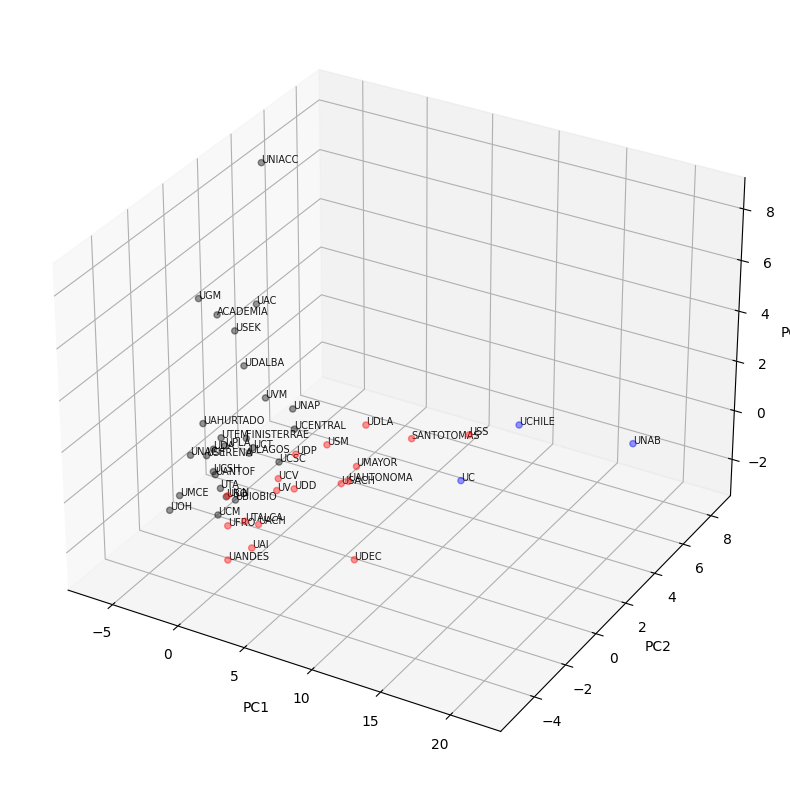

In [26]:
# Grafico de puntos, PC1-PC2-PC3
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(g1['PC1'], g1['PC2'], g1['PC3'], color = 'red', alpha=.4)
ax.scatter(g2['PC1'], g2['PC2'], g2['PC3'], color = 'black', alpha=.4)
ax.scatter(g3['PC1'], g3['PC2'], g3['PC3'], color = 'blue', alpha=.4)

# Etiquetas con los códigos de las Ues
for index, row in g1.iterrows():
  ax.text(row['PC1'], row['PC2'], row['PC3'], row['IES'], fontsize=7, ha='left', alpha=.9)

for index, row in g2.iterrows():
  ax.text(row['PC1'], row['PC2'], row['PC3'], row['IES'], fontsize=7, ha='left', alpha=.9)

for index, row in g3.iterrows():
  ax.text(row['PC1'], row['PC2'], row['PC3'], row['IES'], fontsize=7, ha='left', alpha=.9)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

#Conclusiones
Al describir a las universidades en términos de las componentes principales, las 3 primeras componentes explican más del 60% de la variabilidad de los datos originales, por lo cual se puede reducir la dimensionalidad de los datos a una "más manejable" sin perder tanta información.

Al agrupar las instituciones en este nuevo espacio, en 3 grupos, es posible notar en las representaciones gráficas, el grupo conformado por la UChile, UC y UNAB, bastante separados del resto. Los otros grupos resultantes están conformados por 18 y 27 instituciones.